In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for c in columns :
    print (c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [84]:
columns = inspector.get_columns('station')
for c in columns :
    print (c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [13]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine,reflect=True)

In [14]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
session.query(func.min(Measurement.date)).all()

[('2010-01-01')]

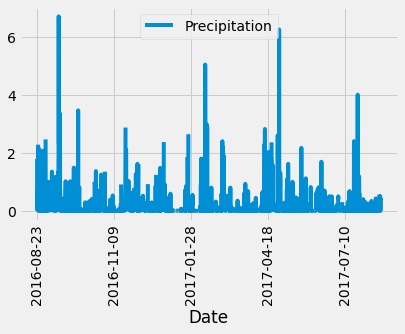

In [83]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostrecent = session.query(func.max(Measurement.date)).first()[0]

# Calculate the date one year from the last date in data set.
yearbefore = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcpq = session.query(Measurement.date, Measurement.prcp).filter(
Measurement.date >= yearbefore).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF = pd.DataFrame(prcpq,columns = ['Date','Precipitation']).set_index('Date')

# Sort the dataframe by date
prcpDF = prcpDF.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcpDF.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()



In [80]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [88]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9)]

In [90]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
MAstation = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
MAstation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [92]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
cal = session.query(*sel).\
    filter(Measurement.station == MAstation[0][0]).all()
cal

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

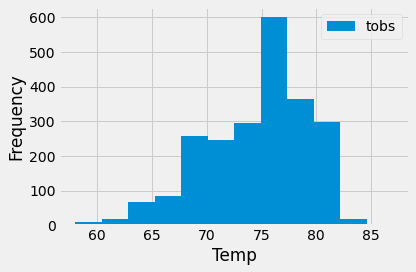

In [93]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histstation = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).all()

yearbefore = dt.date(2017,8,18) - dt.timedelta(days=365)

pcrpqstation = session.query(Measurement.tobs).\
filter(Measurement.date >= yearbefore).all()

pcrpqstationDF = pd.DataFrame(pcrpqstation)

pcrpqstationDF.plot.hist(bins=12)
plt.xlabel("Temp")
plt.tight_layout()
plt.show()

# Close session

In [94]:
# Close Session
session.close()